In [1]:
# Notebook lancé sous Colab, avec TPU v2-8
# aiohttp semble nécessaire pour récupérer les données depuis GitHub
!pip install aiohttp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 27.8 MB/s eta 0:00:00


In [2]:
import aiohttp

# Rendre visible la pollution de l'eau potable

Données disponibles :
* [Eau distribuée par commune gouv.fr](https://www.data.gouv.fr/fr/datasets/resultats-du-controle-sanitaire-de-leau-distribuee-commune-par-commune/)
* [Eau du robinet](https://www.data.gouv.fr/fr/datasets/resultats-du-controle-sanitaire-de-leau-du-robinet/)
* [Base officielle des codes postaux (La Poste)](https://datanova.laposte.fr/datasets/laposte-hexasmal) pour croiser code insee avec une représentation geojson

## 1. Eau distribuée par commune

__Extrait de la doc :__

Le jeu de données se compose de trois types de fichiers. Le lien entre le fichier des prélèvements (PLV) et celui des résultats d’analyse (RESULT) se fait par l’intermédiaire du code du prélèvement (champ ‘referenceprel’). Le fichier UDI_COM détaille le lien entre UDI et communes et permet de pouvoir reconstituer un accès aux résultats par commune ; il est relié au fichier PLV par l’intermédiaire du champ ‘cdreseau’, correspondant au code SISE-Eaux de l’unité de distribution.

### 1.1 Récupération des données (via 1.1.2. pour le moment)
* via s3 à revoir : requête SQL à modifier pour ne pas charger toute la BD, ce qui sature la RAM
* Pour le moment passage par gouv.fr, données .parquet

#### 1.1.1. Via téléchargement s3

In [ ]:
import requests
import duckdb
import dask.dataframe as dd
import pandas as pd
import time

In [ ]:
start_time = time.time()

# Définition du lien de téléchargement de la base DuckDB
url_s3 = 'https://pollution-eau-s3.s3.fr-par.scw.cloud/prod/database/data.duckdb'

# Element de sortie
local_file = 'data.duckdb'

# Récupérer la BD, puis l'écrire en local
response = requests.get(url_s3)
with open(local_file, 'wb') as file:
  file.write(response.content)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

Temps d'exécution : 52.61713266372681 seconds


In [ ]:
# Connexion à la base de données
con = duckdb.connect(database='data.duckdb', read_only=True)

# Listing des tables chargées
tables_df = con.execute("SHOW TABLES").df()
print(tables_df)

# Fermeture de la connexion à la base de données
con.close()

               name
0      edc_communes
1  edc_prelevements
2     edc_resultats


##### Pandas dataframe

In [ ]:
# Récupération des données de la table edc_communes
df_com = con.execute('SELECT * FROM edc_communes').df()
df_com.head()

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,de_partition,de_ingestion_date
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07,2020,2025-02-12
1,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07,2020,2025-02-12
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07,2020,2025-02-12
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07,2020,2025-02-12
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07,2020,2025-02-12


In [ ]:
df_com.shape

(247622, 8)

In [ ]:
# Récupération des données de la table edc_prelevements
df_plv = con.execute('SELECT * FROM edc_prelevements').df()
df_plv.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,de_partition,de_ingestion_date
0,001,001000003,01007,AMBRONAY,None,None,None,00100119766,2020-02-13,11h40,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
1,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100120290,2020-03-17,11h15,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
2,001,001000003,01007,AMBRONAY,None,None,None,00100120717,2020-05-14,11h54,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
3,001,001000003,01007,AMBRONAY,None,None,None,00100121072,2020-06-11,12h00,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
4,001,001000003,01007,AMBRONAY,None,None,None,00100121547,2020-07-08,11h09,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12


In [ ]:
df_plv.shape

(2083345, 20)

In [ ]:
# /!\ FAIT PLANTER LA SESSION, PLUS DE RAM DISPO /!\

# Récupération des données de la table edc_resultats
df_res = con.execute('SELECT * FROM edc_resultats').df()
df_res.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
df_res.shape

In [ ]:
# Fermeture de la connexion à la base de données
con.close()

##### Dask dataframes

In [ ]:
# Pour gérer le jeu de données volumineux
!pip install dask[dataframe]

In [ ]:
start_time = time.time()

# Connexion à la base de données
con = duckdb.connect(database='data.duckdb', read_only=True)

df_com = con.execute('SELECT * FROM edc_communes').fetchdf()

# Fermeture de la connexion à la base de données
con.close()

# Création du dataframe Dask
ddf_com = dd.from_pandas(df_com)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

# Taille du df
print(f'Lignes : {ddf_com.shape[0].compute()}, colonnes : {ddf_com.shape[1]}')

# Premières lignes
ddf_com.head()

Temps d'exécution : 0.48 seconds
Lignes : 247622, colonnes : 8


,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,de_partition,de_ingestion_date
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07,2020,2025-02-12
1,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07,2020,2025-02-12
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07,2020,2025-02-12
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07,2020,2025-02-12
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07,2020,2025-02-12


In [ ]:
start_time = time.time()

# Connexion à la base de données
con = duckdb.connect(database='data.duckdb', read_only=True)

df_plv = con.execute('SELECT * FROM edc_prelevements').fetchdf()

# Fermeture de la connexion à la base de données
con.close()

# Création du dataframe Dask
ddf_plv = dd.from_pandas(df_plv)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

# Taille du df
print(f'Lignes : {ddf_plv.shape[0].compute()}, colonnes : {ddf_plv.shape[1]}')

# Premières lignes
ddf_plv.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Temps d'exécution : 75.25 seconds
Lignes : 2083345, colonnes : 20


,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,de_partition,de_ingestion_date
0,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100119766,2020-02-13,11h40,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
1,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100120290,2020-03-17,11h15,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
2,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100120717,2020-05-14,11h54,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
3,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100121072,2020-06-11,12h00,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12
4,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100121547,2020-07-08,11h09,Eau d'alimentation conforme aux exigences de q...,SI REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,SIE REGION D'AMBERIEU-EN-BUGEY,C,C,C,C,2020,2025-02-12


In [ ]:
# /!\ FAIT PLANTER LA SESSION, PLUS DE RAM DISPO /!\

start_time = time.time()

# Connexion à la base de données
con = duckdb.connect(database='data.duckdb', read_only=True)

df_res = con.execute('SELECT * FROM edc_resultats').fetchdf()

# Fermeture de la connexion à la base de données
con.close()

# Création du dataframe Dask
ddf_res = dd.from_pandas(df_res)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

# Taille du df
print(f'Lignes : {ddf_res.shape[0].compute()}, colonnes : {ddf_res.shape[1]}')

# Premières lignes
ddf_res.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

#### 1.1.2. Via téléchargement en direct depuis gouv.fr, format .parquet

In [3]:
# Pour gérer le jeu de données volumineux
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: importlib_metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [1]:
# Import des modules utilisés
import requests
import time
#import pandas as pd -> Dask utilisé car fichier RESULT très gros
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# CODE POUR ANALYSER 1 JEU DE DONNEES
start_time = time.time()

# Remplacer parmi :
# Fichier COM_UDI : 'https://www.data.gouv.fr/fr/datasets/r/211c23ea-60eb-4b3f-9000-ae319c16cfc9'
# Fichier RESULT : 'https://www.data.gouv.fr/fr/datasets/r/50f3cd73-4ce5-4c04-a45c-f883aae389be'
# Fichier PLV : 'https://www.data.gouv.fr/fr/datasets/r/dd0f0c3a-49dc-4627-8d13-65b463041500'
url_ = 'https://www.data.gouv.fr/fr/datasets/r/50f3cd73-4ce5-4c04-a45c-f883aae389be'

# Fichier d'output (à modifier)
output_re = 'RESULT.parquet'

response = requests.get(url_)
with open(output_re, 'wb') as f:
  f.write(response.content)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

Temps d'exécution : 18.06 seconds


In [2]:
# CODE POUR ANALYSER 3 JEUX DE DONNEES

start_time = time.time()

# Définition des urls contenant les données, au format parquet
# URL COM_UDI
url_cu = 'https://www.data.gouv.fr/fr/datasets/r/211c23ea-60eb-4b3f-9000-ae319c16cfc9'
# URL RESULT
url_re = 'https://www.data.gouv.fr/fr/datasets/r/50f3cd73-4ce5-4c04-a45c-f883aae389be'
# URL PLV
url_pl = 'https://www.data.gouv.fr/fr/datasets/r/dd0f0c3a-49dc-4627-8d13-65b463041500'

# Définition des fichiers
output_cu = 'COM_UDI.parquet'
output_re = 'RESULT.parquet'
output_pl = 'PLV.parquet'

# Association url:fichier
dict_ = {url_cu:output_cu,
         url_re:output_re,
         url_pl:output_pl}

# Téléchargement
for i in range(len(dict_)):
  response = requests.get(list(dict_.keys())[i])
  assert response.status_code == 200 # sinon, erreur : vérif urls
  with open(list(dict_.values())[i], 'wb') as f:
    f.write(response.content)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

Temps d'exécution : 18.68 seconds


In [3]:
start_time = time.time()

# Lecture du fichier COM_UDI
df_cu = dd.read_parquet(output_cu, ignore_metadata_file=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

# Taille du df
print(f'Lignes : {df_cu.shape[0].compute()}, colonnes : {df_cu.shape[1]}')
# Affichage des premières lignes
df_cu.head()

Temps d'exécution : 0.02 seconds
Lignes : 478600, colonnes : 7


,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,annee
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07,2025
1,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07,2025
2,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07,2025
3,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07,2025
4,01005,AMBERIEUX-EN-DOMBES,Est,001000850,BDS CHATANIER,2023-01-01,2025


In [4]:
start_time = time.time()

# Lecture du fichier RESULT
df_re = dd.read_parquet(output_re, ignore_metadata_file=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

# Taille du df
print(f'Lignes : {df_re.shape[0].compute()}, colonnes : {df_re.shape[1]}')
# Affichage des premières lignes
df_re.head()

Temps d'exécution : 0.04 seconds
Lignes : 112923640, colonnes : 18


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
0,001,00100143015,CLVYL,1753.0,CHLORURE DE VINYL MONOMÈRE,Chlorure de vinyl monomère,<NA>,N,L,"0,167",µg/L,133,<=0.5 µg/L,<NA>,0.167000,75-01-4,00100152020,2025
1,001,00100143728,ASP,6489.0,ASPECT (QUALITATIF),Aspect (qualitatif),<NA>,O,L,Aspect normal,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,00100152794,2025
2,001,00100143728,BSIR,1042.0,BACT. ET SPORES SULFITO-RÉDU./100ML,Bact. et spores sulfito-rédu./100ml,<NA>,N,L,<1,n/(100mL),226,<NA>,<=0 n/(100mL),0.000000,<NA>,00100152794,2025
3,001,00100143728,CDT25,1303.0,CONDUCTIVITÉ À 25°C,Conductivité à 25°C,<NA>,N,L,332,µS/cm,147,<NA>,>=200 et <=1100 µS/cm,332.000000,<NA>,00100152794,2025
4,001,00100143728,CL2LIB,1398.0,CHLORE LIBRE,Chlore libre,<NA>,N,T,"<0,05",mg(Cl2)/L,165,<NA>,<NA>,0.000000,<NA>,<NA>,2025


In [5]:
start_time = time.time()

# Lecture du fichier PLV
df_pl = dd.read_parquet(output_pl, ignore_metadata_file=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

# Taille du df
print(f'Lignes : {df_pl.shape[0].compute()}, colonnes : {df_pl.shape[1]}')
# Affichage des premières lignes
df_pl.head()

Temps d'exécution : 0.01 seconds
Lignes : 3726862, colonnes : 19


,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,annee
0,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100143925,2025-01-21,12h35,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2025
1,001,001000241,01364,SAINT-JEAN-SUR-REYSSOUZE,<NA>,<NA>,<NA>,00100143814,2025-01-17,10h00,Eau d'alimentation conforme aux exigences de q...,SI SAONE VEYLE REYSSOUZE SAUR,SAUR FRANCE CHALON-SUR-SAONE,SIE SAONE VEYLE REYSSOUZE,C,C,C,C,2025
2,001,001000241,01025,BAGE-DOMMARTIN,001000483,SVR NORD REPLONGES,0 %,00100143815,2025-01-09,09h15,Eau d'alimentation conforme aux exigences de q...,SI SAONE VEYLE REYSSOUZE SUEZ,SUEZ EAU FRANCE - ARA,SIE SAONE VEYLE REYSSOUZE,C,C,C,C,2025
3,001,001000241,01320,REPLONGES,001000483,SVR NORD REPLONGES,0 %,00100143816,2025-01-28,08h28,Eau d'alimentation conforme aux exigences de q...,SI SAONE VEYLE REYSSOUZE SUEZ,SUEZ EAU FRANCE - ARA,SIE SAONE VEYLE REYSSOUZE,C,C,C,C,2025
4,001,001000241,01323,REYSSOUZE,<NA>,<NA>,<NA>,00100143881,2025-01-17,10h36,Eau d'alimentation conforme aux exigences de q...,SI SAONE VEYLE REYSSOUZE SAUR,SAUR FRANCE CHALON-SUR-SAONE,SIE SAONE VEYLE REYSSOUZE,C,C,C,C,2025


In [6]:
start_time = time.time()

# Lecture du fichier de mapping polluant > catégorie
url_map = 'https://raw.githubusercontent.com/dataforgoodfr/13_pollution_eau/refs/heads/main/dbt_/seeds/mapping_categories.csv'
df_map = dd.read_csv(url_map)

end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} seconds")

# Taille du df
print(f'Lignes : {df_map.shape[0].compute()}, colonnes : {df_map.shape[1]}')
# Affichage des premières lignes
df_map.head()

Temps d'exécution : 0.47 seconds
Lignes : 1612, colonnes : 6


,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,casparam,categorie
0,PESTOT,6276.0,TOTAL DES PESTICIDES ANALYSÉS,Total des pesticides analysés,<NA>,pesticides
1,ATRZ,1107.0,ATRAZINE,Atrazine,1912-24-9,pesticides
2,SMZ,1263.0,SIMAZINE,Simazine,122-34-9,pesticides
3,MTC,1221.0,MÉTOLACHLORE,Métolachlore,51218-45-2,pesticides
4,TBZ,1268.0,TERBUTHYLAZIN,Terbuthylazin,5915-41-3,pesticides


In [7]:
# Vérification que chaque cdparametresiseeaux est lié à une catégorie unique ?
check_ = (
    df_map.groupby('cdparametresiseeaux')['categorie']
    .nunique()
    .reset_index()
    .sort_values(by='categorie', ascending=False))
check_.head()

,cdparametresiseeaux,categorie
819,PFOS,2
1069,HPCDD1,1
1068,PCB,1
1067,PCB20,1
1066,PCB66,1


In [8]:
# TODO : attendre correction fichier source
# En attendant, correction en suivant

# Problème sur PFOS : 2 lignes
df_map[df_map['cdparametresiseeaux']=='PFOS'].compute()

,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,casparam,categorie
826,PFOS,6561.0,ACIDE SULFONIQUE DE PERFLUOROOCTANE,Acide sulfonique de perfluorooctane,1763-23-1,pfas
977,PFOS,6561.0,SULFONATE DE PERFLUOROOCTANE,Sulfonate de perfluorooctane,45298-90-6,hydrocarbure


In [9]:
# TODO : supprimer lorsque corrigé fichier source (cf 2 cellules précédentes)

def update_value(partition):
    if 977 in partition.index:
        partition.loc[977, 'categorie'] = 'pfas'
    return partition

df_map_fix = df_map.map_partitions(update_value).compute()

df_map_fix[df_map_fix['cdparametresiseeaux']=='PFOS']

,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,casparam,categorie
826,PFOS,6561.0,ACIDE SULFONIQUE DE PERFLUOROOCTANE,Acide sulfonique de perfluorooctane,1763-23-1,pfas
977,PFOS,6561.0,SULFONATE DE PERFLUOROOCTANE,Sulfonate de perfluorooctane,45298-90-6,pfas


In [10]:
# Catégories uniques
categ_unique = df_map_fix['categorie'].unique()
print(categ_unique)

<ArrowStringArray>
[               'pesticides',   'métabolite de pesticide',
                   'nitrite',                      'pfas',
                       'cvm', 'sous produit désinfection',
               'perchlorate',             'métaux lourds',
              'hydrocarbure',                       'pcb',
         'dioxine et furane',                  'phtalate',
                    'phénol',                'médicament',
  'paramètre organoleptique',                   'minéral',
                  'microbio',             'radioactivité',
                'non classé']
Length: 19, dtype: string


In [11]:
# Sélection des colonnes d'intérêt pour le mapping
cols_ = ['cdparametresiseeaux', 'categorie']

# Supprimer les doublons
df_map_fin = df_map_fix[cols_].drop_duplicates()
df_map_fin.shape

(1594, 2)

### 1.2. Analyse des données

#### 1.2.1. Analyse df_cu
* Contient un mapping entre les communes et les cdr
* inseecommune plus fin que nomcommune, mais non uniques
  * cdreseau + quartier permet de différencier
* Plus de nomreseau que de cdreseau : pourquoi ?


Description des colonnes :

| Nom Colonne | Description | Type de champ |
|-------------|-------------|---------------|
| Inseecommune | Code Insee de la commune du point de surveillance | Chaîne de caractère(5) |
| Nomcommune | Nom de la commune alimentée par le réseau | Chaîne de caractère |
| Quartier | Quartier alimenté par le réseau | Chaîne de caractère |
| Cdreseau | Code de l’installation (unité de distribution) | Chaîne de caractère(9) |
| Nomreseau | Nom de l’installation |Chaîne de caractère |
| Debutalim | Date de début d’alimentation du quartier |Chaîne de caractère |

In [ ]:
df_cu.head()

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,annee
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07,2024
1,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07,2024
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07,2024
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07,2024
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07,2024


In [ ]:
annees_unique = df_cu['annee'].unique()
print(annees_unique.compute())

0    2024
1    2023
2    2022
3    2021
4    2020
5    2019
6    2018
7    2017
8    2016
Name: annee, dtype: int32


In [ ]:
# Données en 2024
len(df_cu[df_cu['annee']==2024].compute())

49536

In [ ]:
# Données depuis 2020 (inclus)
len(df_cu[df_cu['annee']<=2020].compute())

246607

Analyse sur les données 2024

In [ ]:
df_cu_2024 = df_cu[df_cu['annee']==2024].compute()
df_cu_2024.shape

(49536, 7)

Identification de la clé unique

In [ ]:
# Nombre de inseecommune uniques
inseecommune_unique = len(df_cu_2024['inseecommune'].unique())
print(inseecommune_unique)

34809


In [ ]:
# Nombre de nomcommune uniques
nomcommune_unique = len(df_cu_2024['nomcommune'].unique())
print(nomcommune_unique)

32502


In [ ]:
# Nombre de inseecommune par nomcommune, >1
insee_par_com = (
    df_cu_2024.groupby('nomcommune')['inseecommune']
    .nunique()
    .reset_index()
    .sort_values(by='inseecommune', ascending=False))
insee_par_com[insee_par_com['inseecommune']>1]

,nomcommune,inseecommune
27011,SAINTE-COLOMBE,12
26656,SAINT-SAUVEUR,11
26546,SAINT-REMY,10
24028,SAINT-AUBIN,10
2432,BEAULIEU,10
...,...,...
2557,BEAUVOISIN,2
14368,LAGARRIGUE,2
31796,VILLIERS,2
10634,FERRIERE (LA),2


In [ ]:
# Données pour SAINTE-COLOMBE
df_cu_2024[df_cu_2024['nomcommune']=='SAINTE-COLOMBE']

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,annee
2666,05135,SAINTE-COLOMBE,-,005001294,SAINTE COLOMBE CHEF LIEU,2010-08-07,2024
2667,05135,SAINTE-COLOMBE,-,005001295,LES BEGUES (STE COLOMBE),2010-08-07,2024
9023,17319,SAINTE-COLOMBE,totalité,017000475,R. DE MONTLIEU-MONTGUYON,2010-09-15,2024
12759,25515,SAINTE-COLOMBE,-,025000744,CCGP SAINTE COLOMBE,2010-07-27,2024
17718,33390,SAINTE-COLOMBE,-,033000454,EST-DU-LIBOURNAIS,2010-10-15,2024
18684,35262,SAINTE-COLOMBE,(sauf zone Ouest),035000137,FORET THEIL_CITE_RETIERS,2010-08-05,2024
21309,40252,SAINTE-COLOMBE,-,040000341,MARSEILLON,2014-01-01,2024
23560,46260,SAINTE-COLOMBE,-,046000545,LONGUECOSTE,2010-08-14,2024
26912,50457,SAINTE-COLOMBE,-,050000618,LA GATHE,2010-10-20,2024
38672,69189,SAINTE-COLOMBE,-,069000128,STE COLOMBE ST ROMAIN EN GAL,2010-09-07,2024


In [ ]:
# Nombre de nomcommune par inseecommune, >1
com_par_insee = (
    df_cu_2024.groupby('inseecommune')['nomcommune']
    .nunique()
    .reset_index()
    .sort_values(by='nomcommune', ascending=False))
com_par_insee[com_par_insee['nomcommune']>1]

,inseecommune,nomcommune


In [ ]:
# Vérifier si inseecommune + cdreseau = clé unique ?
insee_cdr = (
    df_cu_2024.groupby(['inseecommune', 'cdreseau'])
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
insee_cdr.head()

,inseecommune,cdreseau,Counts
23466,48009,048000698,43
24033,48178,048000240,36
23961,48155,048001486,34
23750,48095,048000271,27
23616,48051,048000055,26


In [ ]:
df_cu_2024[(df_cu_2024['inseecommune']=='48009') &
 (df_cu_2024['cdreseau']=='048000698')].head(10)

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,annee
24118,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / Aumont-Aubrac,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24119,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / Buffeyrettes,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24120,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / L'Adrech,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24121,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / La Baraque Blanche,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24122,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / La Baraque de Petit,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24123,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / La Baraque des Bois,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24124,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / La Chazotte,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24125,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / La Combe,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24126,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / La Croix,048000698,AUMONT-LA CHAZE,2017-01-01,2024
24127,48009,PEYRE EN AUBRAC,AUMONT-AUBRAC / La Ferme de Bouscas,048000698,AUMONT-LA CHAZE,2017-01-01,2024


In [ ]:
# Et avec le quartier ?
insee_cdr_qtr = (
    df_cu_2024.groupby(['inseecommune', 'cdreseau', 'quartier'])
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
insee_cdr_qtr.head()

,inseecommune,cdreseau,quartier,Counts
0,01001,001000556,-,1
32992,60624,060001557,-,1
33018,60647,060001010,-,1
33019,60648,060000581,-,1
33020,60650,060000616,-,1


Analyse cdreseau et nomreseau

In [ ]:
# Nombre de cdreseau uniques
cdreseau_unique = len(df_cu_2024['cdreseau'].unique())
print(cdreseau_unique)

23184


In [ ]:
# Nombre de nomreseau uniques
nomreseau_unique = len(df_cu_2024['nomreseau'].unique())
print(nomreseau_unique)

22812


In [ ]:
# Nombre de cdreseau par nomreseau, >1
cdr_par_nomreseau = (
    df_cu_2024.groupby('nomreseau')['cdreseau']
    .nunique()
    .reset_index()
    .sort_values(by='cdreseau', ascending=False))
cdr_par_nomreseau[cdr_par_nomreseau['cdreseau']>1]

,nomreseau,cdreseau
10906,LES COMBES,6
6828,FERRIERES,6
10469,LE MAS,5
9569,LA ROCHE,5
16087,RESEAU PRINCIPAL,5
...,...,...
11629,LUC,2
14368,PLAGNE,2
11686,LUSCLADE,2
11355,LIMOUSIS,2


In [ ]:
# Données pour LES COMBES
df_cu_2024[df_cu_2024['nomreseau']=='LES COMBES']

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,annee
2795,05184,VITROLLES,-,005002104,LES COMBES,2010-08-07,2024
12378,25160,COMBES (LES),-,025000967,LES COMBES,2010-07-27,2024
24344,48019,BARRE-DES-CEVENNES,Balmégouse,048002296,LES COMBES,2010-09-02,2024
24345,48019,BARRE-DES-CEVENNES,La Pio,048002296,LES COMBES,2010-09-02,2024
24346,48019,BARRE-DES-CEVENNES,Les Combes,048002296,LES COMBES,2010-09-02,2024
24445,48029,BORN (LE),Les Combes,048000906,LES COMBES,2010-09-02,2024
35044,63117,COMPAINS,Les Combes,063002863,LES COMBES,2010-09-16,2024
35045,63117,COMPAINS,Les Creux,063002863,LES COMBES,2010-09-16,2024
46988,87159,SAINT-LEGER-LA-MONTAGNE,village des Combes,087003674,LES COMBES,2017-02-02,2024


In [ ]:
# LES COMBES dans nomcommunes ?
to_search = 'COMBES'
df_cu_2024['nomcommune'].str.contains(to_search).any()

True

In [ ]:
df_cu_2024[df_cu_2024['nomcommune'].str.contains(to_search)]

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,annee
8604,16331,SAINT-LAURENT-DES-COMBES,-,016000382,MONTMORELIEN,2010-09-02,2024
12095,24456,SAINT-MARTIN-DES-COMBES,-,024000031,SAINT GEORGES DE MONTCLARD,2010-10-15,2024
12377,25160,COMBES (LES),Hameau de Remonot,025000210,REMONOT,2010-07-27,2024
12378,25160,COMBES (LES),-,025000967,LES COMBES,2010-07-27,2024
17752,33426,SAINT-LAURENT-DES-COMBES,-,033000454,EST-DU-LIBOURNAIS,2010-10-15,2024
17998,34083,COMBES,bourg st vital log.n,034000147,COMBES-BOURG-ST VITAL-LOGIS N.,2010-11-06,2024
17999,34083,COMBES,Lamalou le Vieux,034003834,COMBES-LAMALOU LE VIEUX,2010-11-06,2024
46982,87155,SAINT-JUNIEN-LES-COMBES,-,087000106,BEISSAT,2021-08-24,2024


#### 1.2.2. Analyse df_pl
* Fichier recensant les prélèvements effectués
* Clé unique = cdreseau + referenceprel


Description des colonnes :

| Nom Colonne | Description | Type de champ |
|-------------|-------------|---------------|
| Cddept | Département gestionnaire (DD-ARS) | Chaîne de caractère(3) |
| Cdreseau | Code SISE-Eaux de l’installation (unité de distribution) | Chaîne de caractère(9) |
| Inseecommuneprinc | Code Insee de la commune du point de surveillance sur lequel est réalisé le prélèvement | Chaîne de caractère(5) |
| Nomcommuneprinc | Nom de la commune du point de surveillance sur lequel est réalisé le prélèvement | Chaîne de caractère |
| Cdreseauamont | Code SISE-Eaux de l’installation amont | Chaîne de caractère(9) |
| Nomreseauamont | Nom de l’installation amont | Chaîne de caractère |
| Pourcentdebit | Pourcentage de débit de l’installation amont | Pourcentage |
| Referenceprel | Code SISE-Eaux du prélèvement | Chaîne de caractère(11) |
| Dateprel | Date du prélèvement | Date |
| Heureprel | Heure du prélèvement | Chaîne de caractère |
| Conclusionprel | Conclusion sanitaire du prélèvement | Chaîne de caractère |
| Ugelib | Libellé de l’unité de gestion (service public de distribution) | Chaîne de caractère |
| Distrlib | Nom de l'organisme exploitant (responsable de la distribution) | Chaîne de caractère |
| Moalib | Nom du maître d’ouvrage | Chaîne de caractère |
| Plvconformitebacterio | Conformité bactériologique du prélèvement aux limites de qualité | Chaîne de caractère(1) |
| Plvconformitechimique | Conformité physico-chimique du prélèvement aux limites de qualité | Chaîne de caractère(1) |
| plvconformitereferencebact | Conformité bactériologique du prélèvement aux références de qualité | Chaîne de caractère(1) |
| plvconformitereferencechim | Conformité chimique du prélèvement aux références de qualité | Chaîne de caractère(1) |

In [ ]:
df_pl.head()

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,annee
0,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100139034,2024-01-23,11h27,Eau d'alimentation conforme aux limites de qua...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,N,C,2024
1,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100139393,2024-02-13,12h49,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024
2,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100139969,2024-03-13,10h46,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024
3,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100140209,2024-04-05,07h27,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024
4,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100140543,2024-05-13,12h43,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024


In [ ]:
annees_unique = df_pl['annee'].unique()
print(annees_unique.compute())

0    2023
1    2022
2    2018
0    2024
1    2021
2    2019
3    2016
0    2020
1    2017
Name: annee, dtype: int32


In [ ]:
# Données en 2024
len(df_pl[df_pl['annee']==2024].compute())

416128

In [ ]:
# Données depuis 2020
len(df_pl[df_pl['annee']<=2020].compute())

2019990

Analyse sur les données 2024

In [ ]:
df_pl_2024 = df_pl[df_pl['annee']==2024].compute()
df_pl_2024.shape

(416128, 19)

Recherche de la clé unique

In [ ]:
# Avec cdreseau et inseecommuneprinc
cdr_inseep = (
    df_pl_2024.groupby(['cdreseau', 'inseecommuneprinc'])
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
cdr_inseep.head()

,cdreseau,inseecommuneprinc,Counts
9216,013000577,13055,796
9259,013006573,13055,704
9270,013006623,13055,703
9260,013006613,13055,702
9269,013006622,13055,702


In [ ]:
# Avec referenceprel
refplv = (
    df_pl_2024.groupby('referenceprel')
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
refplv.head()

,referenceprel,Counts
35750,01100176795,66
35661,01100172181,66
32732,01100165986,55
35707,01100172283,55
34829,01100169160,55


In [ ]:
# Avec cdreseau et referenceprel
cdr_refplv = (
    df_pl_2024.groupby(['cdreseau', 'referenceprel'])
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
cdr_refplv.head()

,cdreseau,referenceprel,Counts
0,001000003,00100139034,1
277415,063001684,06300209620,1
277425,063001686,06300213597,1
277424,063001686,06300212291,1
277423,063001686,06300209795,1


In [ ]:
# TODO : croiser avec analyse df_re

#### 1.2.3. Analyse df_re
* Contient les résultats d'analyse par prélèvement/paramètre
* Clé unique = referenceprel + cdparametresiseeaux + referenceanl

Description des colonnes :

| Nom Colonne | Description | Type de champ |
|-------------|-------------|---------------|
| Cddept | Département gestionnaire (DD-ARS) | Chaîne de caractère(3) |
| Referenceprel | Code SISE-Eaux du prélèvement | Chaîne de caractère(11) |
| Cdparametresiseeaux | Code SISE-Eaux du paramètre | Chaîne de caractère(10) |
| Cdparametre | Code SANDRE du paramètre | Numérique (5) |
| libMAJparametre | Nom du paramètre en majuscule | Chaîne de caractère |
| libMINparametre | Nom du paramètre en minuscule | Chaîne de caractère |
| libWEBparametre | Nom du paramètre "grand public" | Chaîne de caractère |
| Qualitparam | Paramètre qualitatif -> O Paramètre quantitatif -> N | Chaîne de caractère (1) O/N |
| Insituana | Type de résultat Terrain ou Laboratoire | Chaîne de caractère(1) T/L |
| Rqana | Résultat (si paramètre qualitatif, libellé correspondant) | Chaîne de caractère(8) |
| cdunitereferencesiseeaux | Unité | Chaîne de caractère(7) |
| Cdunitereference | Code SANDRE Unité | Chaîne de caractère |
| Limitequal | Limite(s) qualité | Chaîne de caractère |
| Refqual | Référence(s) qualité | Chaîne de caractère |
| ValTraduite | Valeur traduite du résultat au format numérique | Numérique |
| Casparam | Code CAS du paramètre | Numérique (15) |
| ReferenceAnl | Code de l’analyse faite en laboratoire | Chaîne de caractère |

In [12]:
df_re.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
0,001,00100143015,CLVYL,1753.0,CHLORURE DE VINYL MONOMÈRE,Chlorure de vinyl monomère,<NA>,N,L,"0,167",µg/L,133,<=0.5 µg/L,<NA>,0.167000,75-01-4,00100152020,2025
1,001,00100143728,ASP,6489.0,ASPECT (QUALITATIF),Aspect (qualitatif),<NA>,O,L,Aspect normal,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,00100152794,2025
2,001,00100143728,BSIR,1042.0,BACT. ET SPORES SULFITO-RÉDU./100ML,Bact. et spores sulfito-rédu./100ml,<NA>,N,L,<1,n/(100mL),226,<NA>,<=0 n/(100mL),0.000000,<NA>,00100152794,2025
3,001,00100143728,CDT25,1303.0,CONDUCTIVITÉ À 25°C,Conductivité à 25°C,<NA>,N,L,332,µS/cm,147,<NA>,>=200 et <=1100 µS/cm,332.000000,<NA>,00100152794,2025
4,001,00100143728,CL2LIB,1398.0,CHLORE LIBRE,Chlore libre,<NA>,N,T,"<0,05",mg(Cl2)/L,165,<NA>,<NA>,0.000000,<NA>,<NA>,2025


In [13]:
# Ajout de la catégorisation du polluant
df_re_m = dd.merge(df_re,
                   df_map_fin,
                   on='cdparametresiseeaux',
                   how='left')
df_re_m.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
0,001,00100143015,CLVYL,1753.0,CHLORURE DE VINYL MONOMÈRE,Chlorure de vinyl monomère,<NA>,N,L,"0,167",µg/L,133,<=0.5 µg/L,<NA>,0.167000,75-01-4,00100152020,2025,cvm
1,001,00100143728,ASP,6489.0,ASPECT (QUALITATIF),Aspect (qualitatif),<NA>,O,L,Aspect normal,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,00100152794,2025,paramètre organoleptique
2,001,00100143728,BSIR,1042.0,BACT. ET SPORES SULFITO-RÉDU./100ML,Bact. et spores sulfito-rédu./100ml,<NA>,N,L,<1,n/(100mL),226,<NA>,<=0 n/(100mL),0.000000,<NA>,00100152794,2025,microbio
3,001,00100143728,CDT25,1303.0,CONDUCTIVITÉ À 25°C,Conductivité à 25°C,<NA>,N,L,332,µS/cm,147,<NA>,>=200 et <=1100 µS/cm,332.000000,<NA>,00100152794,2025,paramètre organoleptique
4,001,00100143728,CL2LIB,1398.0,CHLORE LIBRE,Chlore libre,<NA>,N,T,"<0,05",mg(Cl2)/L,165,<NA>,<NA>,0.000000,<NA>,<NA>,2025,sous produit désinfection


In [14]:
# Suppression des lignes pour les catégories non considérées
categ_remov = ['dioxine et furane', 'paramètre organoleptique', 'minéral',
               'microbio', 'radioactivité']

df_re_categ = df_re_m[~df_re_m['categorie'].isin(categ_remov)].compute()
df_re_categ.shape

(69308456, 19)

##### Suppression des lignes sans intérêt d'après la colonne rqana
* D'après la documentation, les lignes sont traduites ainsi (entre rqana et valtraduite) :

| Résultat | Valeur traduite | Commentaire |
|----------|-----------------|-------------|
| XXX | XXX | |
| -XXX | -XXX | |
| <XXX | 0 | |
| >XXX | XXX | |
| TRACES | 0 | Entre seuil de quantification et de détection. |
| INCOMPT. | 1,11 | Valeur trop élevée en microbiologie. Préférer >XXX. |
| PRESENCE | 1 | Présence non quantifiée. |
| N.D. | 0 | < seuil de détection. |
| ILLISIBL | NULL | Non interprétable en bactériologie. |
| <SEUIL | 0 | < seuil de détection. |
| N.M. | NULL | Non fait, perdu. |

* Aucune ligne pour PRESENCE et ILLISIBL
* N.D. et <SEUIL contiennent la même information (aucune action)
* INCOMPT. et N.M. non considérés (ne peut pas être exploité)

In [17]:
# Lignes pour lesquelles rqana = TRACES
rqana_traces = df_re_categ[df_re_categ['rqana'] == 'TRACES']
print(f'{rqana_traces.shape[0]} lignes.')
rqana_traces.head()

Lignes : 257, colonnes : 19


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
500319,085,08500454802,AMPA,1907.0,AMPA,AMPA,<NA>,N,L,TRACES,µg/L,133,"<=0,1 µg/L",<NA>,0.000000,1066-51-9,08500382638,2022,métabolite de pesticide
500509,085,08500454802,LCLESA,6800.0,ESA ALACHLORE,ESA alachlore,<NA>,N,L,TRACES,µg/L,133,<NA>,<NA>,0.000000,142363-53-9,08500382638,2022,métabolite de pesticide
500536,085,08500454802,MTCOXA,6853.0,OXA METOLACHLORE,OXA metolachlore,<NA>,N,L,TRACES,µg/L,133,<NA>,<NA>,0.000000,152019-73-3,08500382638,2022,métabolite de pesticide
500543,085,08500454802,MTZCESA,6895.0,ESA METAZACHLORE,ESA metazachlore,<NA>,N,L,TRACES,µg/L,133,<NA>,<NA>,0.000000,172960-62-2,08500382638,2022,métabolite de pesticide
526417,085,08500458457,MTCOXA,6853.0,OXA METOLACHLORE,OXA metolachlore,<NA>,N,L,TRACES,µg/L,133,<NA>,<NA>,0.000000,152019-73-3,08500386293,2022,métabolite de pesticide


In [19]:
# Lignes pour lesquelles rqana = INCOMPT.
rqana_incompt = df_re_categ[df_re_categ['rqana'] == 'INCOMPT.']
print(f'{rqana_incompt.shape[0]} lignes.')
rqana_incompt.head()

Lignes : 2, colonnes : 19


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
210498,071,07100125833,CO2CAL,NaN,CO2 LIBRE CALCULÉ,CO2 libre calculé,<NA>,N,L,INCOMPT.,mg/L,162,<NA>,<NA>,1.110000,124-38-9,07100133692,2024,non classé
153015,022,02200196952,CL2COMB,1755.0,CHLORE COMBINÉ,Chlore combiné,<NA>,N,T,INCOMPT.,mg(Cl2)/L,165,<NA>,<NA>,1.110000,<NA>,<NA>,2018,sous produit désinfection


In [20]:
# Lignes pour lesquelles rqana = PRESENCE.
rqana_presence = df_re_categ[df_re_categ['rqana'] == 'PRESENCE.']
print(f'{rqana_presence.shape[0]} lignes.')
rqana_presence.head()

Lignes : 0, colonnes : 19


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie


In [21]:
# Lignes pour lesquelles rqana = ILLISIBL.
rqana_illisibl = df_re_categ[df_re_categ['rqana'] == 'ILLISIBL.']
print(f'{rqana_illisibl.shape[0]} lignes.')
rqana_illisibl.head()

0 lignes.


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie


In [22]:
# Lignes pour lesquelles rqana = N.M.
rqana_nm = df_re_categ[df_re_categ['rqana'] == 'N.M.']
print(f'{rqana_nm.shape[0]} lignes.')
rqana_nm.head()

281683 lignes.


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
2328,001,00100143866,CLO2,1754.0,BIOXYDE DE CHLORE MG/L CLO2,Bioxyde de chlore mg/L ClO2,<NA>,N,T,N.M.,mg/L,162,<NA>,<NA>,<NA>,10049-04-4,<NA>,2025,sous produit désinfection
2348,001,00100143866,O3,1746.0,OZONE,Ozone,<NA>,N,T,N.M.,mg/L,162,<NA>,<NA>,<NA>,10028-15-6,<NA>,2025,sous produit désinfection
2374,001,00100143867,CLO2,1754.0,BIOXYDE DE CHLORE MG/L CLO2,Bioxyde de chlore mg/L ClO2,<NA>,N,T,N.M.,mg/L,162,<NA>,<NA>,<NA>,10049-04-4,<NA>,2025,sous produit désinfection
2394,001,00100143867,O3,1746.0,OZONE,Ozone,<NA>,N,T,N.M.,mg/L,162,<NA>,<NA>,<NA>,10028-15-6,<NA>,2025,sous produit désinfection
2420,001,00100143868,CLO2,1754.0,BIOXYDE DE CHLORE MG/L CLO2,Bioxyde de chlore mg/L ClO2,<NA>,N,T,N.M.,mg/L,162,<NA>,<NA>,<NA>,10049-04-4,<NA>,2025,sous produit désinfection


In [23]:
# Sélection des lignes
lst_remov = ['INCOMPT.', 'N.M.']

df_re_rq = df_re_categ[~df_re_categ['rqana'].isin(lst_remov)]
df_re_rq.shape

(69026771, 19)

##### Sélection sur l'année

In [24]:
annees_unique = df_re_rq['annee'].unique()
print(annees_unique)

[2025 2024 2023 2022 2021 2020 2019 2018 2017 2016]


In [25]:
# Données en 2024
len(df_re_rq[df_re_rq['annee']==2024])

7447716

In [26]:
# Données depuis 2020 (inclus)
len(df_re_rq[df_re_rq['annee']>=2020])

39799381

In [27]:
# Sélection sur l'année 2024 pour première étude
df_re_2024 = df_re_rq[df_re_rq['annee']==2024]
df_re_2024.shape

(7447716, 19)

In [28]:
# Vérification du nombre de lignes dupliquées
print(f'Il y a {df_re_2024.duplicated().sum()} lignes dupliquées.')

Il y a 0 lignes dupliquées.


##### Recherche de la clé unique

In [29]:
# Avec referenceprel
refplv = (
    df_re_2024.groupby('referenceprel')
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
refplv.head()

,referenceprel,Counts
248192,08300288944,670
246893,08300285318,670
246097,08300283106,669
246658,08300284430,668
246659,08300284431,668


In [30]:
# Avec referenceprel et cdparametresiseeaux
refplv_sise = (
    df_re_2024.groupby(['referenceprel', 'cdparametresiseeaux'])
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
refplv_sise.head()

,referenceprel,cdparametresiseeaux,Counts
187592,00300100008,EFOSITE,2
187593,00300100008,ENDOA,2
187594,00300100008,ENDOB,2
187595,00300100008,ENDOT,2
187597,00300100008,EPOXCZ,2


In [31]:
# Extrait pour la première ligne
df_re_2024[(df_re_2024['referenceprel']=='00300100008') &
 (df_re_2024['cdparametresiseeaux']=='EFOSITE')]

# Lignes en doublons si referenceanl non considéré

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
108927,003,00300100008,EFOSITE,1975.0,FOSETYL-ALUMINIUM,Fosetyl-aluminium,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,39148-24-8,00300103371,2024,pesticides
108928,003,00300100008,EFOSITE,1975.0,FOSETYL-ALUMINIUM,Fosetyl-aluminium,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,39148-24-8,00300103373,2024,pesticides


In [34]:
# Combien de lignes en doublon ?
refplv_sise[refplv_sise['Counts']==2].shape

# TODO : inspecter ces lignes pour voir si même info qui ressort ?

(850, 3)

In [32]:
# Avec referenceprel, cdparametresiseeaux et referenceanl
refplvanl_sise = (
    df_re_2024.groupby(['referenceprel', 'cdparametresiseeaux', 'referenceanl'])
    .size()
    .reset_index(name='Counts')
    .sort_values(by='Counts', ascending=False))
refplvanl_sise.head()

,referenceprel,cdparametresiseeaux,referenceanl,Counts
6880207,97600032333,NO3,97600042532,1
0,00100138843,ACPT,00100147616,1
1,00100138843,ACRYL,00100147616,1
2,00100138843,ANTHRA,00100147616,1
3,00100138843,BAPYR,00100147616,1


##### Répartition par catégorie

In [36]:
# Répartition par catégorie
nb_par_cat = (
    df_re_2024.groupby('categorie')['referenceprel']
    .count()
    .reset_index()
    .sort_values(by='referenceprel', ascending=False))
print(type(nb_par_cat))

<class 'pandas.core.frame.DataFrame'>


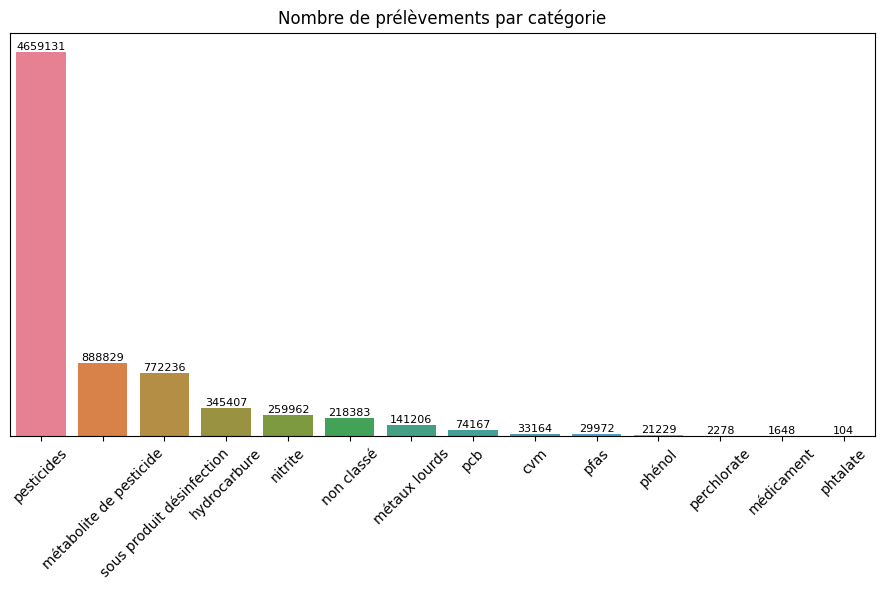

In [37]:
# Size of the plot
plt.figure(figsize=(9, 6))

ax = sns.barplot(x='categorie', y='referenceprel', hue='categorie' ,data=nb_par_cat)
plt.xticks(rotation=45)
ax.set_title('Nombre de prélèvements par catégorie')
ax.set(xlabel='', ylabel='', yticks=[])

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=8)

plt.tight_layout()
plt.show()

##### Analyse des colonnes pour sélection
* `libwebparametre` ne contient que la valeur \<NA>, donc non utile
* `qualitparam` = `O` ne contient aucune information utile
* `cdunitereferencesiseeaux` = `°C` (1 ligne) à ne pas considérer
* `cdunitereferencesiseeaux` = `NG/(KG POIDS CORPOREL/J)` (620 lignes, équivalent toxique HAP) : peut être creusé
* `cdunitereferencesiseeaux` = `°f` (4496 lignes) semble non utile
* `cdunitereferencesiseeaux` = `%` (1911 lignes) semble non utile

In [38]:
# TODO : analyser col non utilisées
df_re_2024.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
662551,001,00100138503,CL2LIB,1398.0,CHLORE LIBRE,Chlore libre,<NA>,N,T,"0,30",mg(Cl2)/L,165,<NA>,<NA>,0.300000,<NA>,<NA>,2024,sous produit désinfection
662552,001,00100138503,CL2TOT,1399.0,CHLORE TOTAL,Chlore total,<NA>,N,T,"0,34",mg(Cl2)/L,165,<NA>,<NA>,0.340000,<NA>,<NA>,2024,sous produit désinfection
662564,001,00100138632,CL2LIB,1398.0,CHLORE LIBRE,Chlore libre,<NA>,N,T,"0,32",mg(Cl2)/L,165,<NA>,<NA>,0.320000,<NA>,<NA>,2024,sous produit désinfection
662565,001,00100138632,CL2TOT,1399.0,CHLORE TOTAL,Chlore total,<NA>,N,T,"0,34",mg(Cl2)/L,165,<NA>,<NA>,0.340000,<NA>,<NA>,2024,sous produit désinfection
662579,001,00100138843,ACPT,1453.0,ACÉNAPHTÈNE,Acénaphtène,<NA>,N,L,"0,002",µg/L,133,<NA>,<NA>,0.002000,83-32-9,00100147616,2024,hydrocarbure


In [39]:
# Paramètre siseeaux uniques
cdparametresiseeaux_uniques = df_re_2024['cdparametresiseeaux'].unique()
len(cdparametresiseeaux_uniques)

1079

In [40]:
# Lib paramètre (min) uniques
libminparametre_uniques = df_re_2024['libminparametre'].unique()
len(libminparametre_uniques)

1078

In [41]:
# Lib paramètre (web) uniques
libwebparametre_uniques = df_re_2024['libwebparametre'].unique()
len(libwebparametre_uniques)

1

In [42]:
# Vérifier que les seules valeurs sont O (qualitatif) ou N (quantitatif)
df_re_2024['qualitparam'].unique()

<ArrowStringArray>
['N', 'O']
Length: 2, dtype: string

In [43]:
# Quels sont les paramètres dits "qualitatifs" ?
df_quali = df_re_2024[df_re_2024['qualitparam']=='O']
df_quali.sample(7, random_state=23)

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
572543,047,04700082120,PLVACR,NaN,PRÉLÈVEMENT SOUS ACRÉDITATION,Prélèvement sous acréditation,<NA>,O,T,OUI,SANS OBJET,X,<NA>,<NA>,1.000000,<NA>,<NA>,2024,non classé
350840,031,03100211975,PLVACR,NaN,PRÉLÈVEMENT SOUS ACRÉDITATION,Prélèvement sous acréditation,<NA>,O,T,OUI,SANS OBJET,X,<NA>,<NA>,1.000000,<NA>,<NA>,2024,non classé
276290,031,03100204103,PLVACR,NaN,PRÉLÈVEMENT SOUS ACRÉDITATION,Prélèvement sous acréditation,<NA>,O,T,OUI,SANS OBJET,X,<NA>,<NA>,1.000000,<NA>,<NA>,2024,non classé
293989,031,03100204676,PLVACR,NaN,PRÉLÈVEMENT SOUS ACRÉDITATION,Prélèvement sous acréditation,<NA>,O,T,OUI,SANS OBJET,X,<NA>,<NA>,1.000000,<NA>,<NA>,2024,non classé
333271,031,03100205914,PLVACR,NaN,PRÉLÈVEMENT SOUS ACRÉDITATION,Prélèvement sous acréditation,<NA>,O,T,OUI,SANS OBJET,X,<NA>,<NA>,1.000000,<NA>,<NA>,2024,non classé
294500,031,03100204697,PLVACR,NaN,PRÉLÈVEMENT SOUS ACRÉDITATION,Prélèvement sous acréditation,<NA>,O,T,OUI,SANS OBJET,X,<NA>,<NA>,1.000000,<NA>,<NA>,2024,non classé
244519,031,03100203194,PLVACR,NaN,PRÉLÈVEMENT SOUS ACRÉDITATION,Prélèvement sous acréditation,<NA>,O,T,OUI,SANS OBJET,X,<NA>,<NA>,1.000000,<NA>,<NA>,2024,non classé


In [44]:
# Quelles sont les paramètres concernés ?
df_quali['libminparametre'].unique()

<ArrowStringArray>
['Hydrogène sulfuré (qualitatif)',  'Prélèvement sous acréditation',
    'Dispo. intérieur traitement']
Length: 3, dtype: string

In [45]:
# Analyse des lignes pour Hydrogène sulfuré (qualitatif)
df_quali[df_quali['libminparametre']=='Hydrogène sulfuré (qualitatif)']

# => A ne pas considérer

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
286053,005,00500131460,H2SQ,5906.0,HYDROGÈNE SULFURÉ (QUALITATIF),Hydrogène sulfuré (qualitatif),<NA>,O,L,Absence d'odeur sulfurée,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,00500139901,2024,hydrocarbure


In [46]:
# Analyse des lignes pour Dispo. intérieur traitement
df_quali[df_quali['libminparametre']=='Dispo. intérieur traitement']

# => A ne pas considérer

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
686095,022,02200232339,DISPTRT,5905.0,DISPO. INTÉRIEUR TRAITEMENT,Dispo. intérieur traitement,<NA>,O,L,Pas de dipositif de traitement,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,02200229958,2024,non classé
710020,022,02200233939,DISPTRT,5905.0,DISPO. INTÉRIEUR TRAITEMENT,Dispo. intérieur traitement,<NA>,O,L,Pas de dipositif de traitement,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,02200231558,2024,non classé
759668,022,02200236011,DISPTRT,5905.0,DISPO. INTÉRIEUR TRAITEMENT,Dispo. intérieur traitement,<NA>,O,L,Pas de dipositif de traitement,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,02200233627,2024,non classé
792234,022,02200237293,DISPTRT,5905.0,DISPO. INTÉRIEUR TRAITEMENT,Dispo. intérieur traitement,<NA>,O,L,Pas de dipositif de traitement,SANS OBJET,X,<NA>,<NA>,0.000000,<NA>,02200234909,2024,non classé


In [47]:
# Analyse des lignes pour Dispo. intérieur traitement
df_quali[df_quali['libminparametre']=='Prélèvement sous acréditation'].shape

(5851, 19)

In [48]:
df_quali[df_quali['libminparametre']=='Prélèvement sous acréditation']['rqana'].unique()

<ArrowStringArray>
['OUI']
Length: 1, dtype: string

In [49]:
# Vérifier que les seules valeurs sont T (terrain) ou L (laboratoire)
df_re_2024['insituana'].unique()

<ArrowStringArray>
['T', 'L']
Length: 2, dtype: string

In [50]:
# Valeurs uniques sur rqana
df_re_2024['rqana'].unique()

<ArrowStringArray>
[    '0,30',     '0,34',     '0,32',    '0,002',    '<0,10',   '<0,001',
  '<0,0001',  '<0,0005', '<0,00050',       '<1',
 ...
   '0,1447',    '20,33', '<0,00020',  '0,00177',     '>2,0',    '28,99',
    '21,47',    '33,51',  '0,00330',      '096']
Length: 12332, dtype: string

In [51]:
# Valeurs uniques sur cdunitereferencesiseeaux
df_re_2024['cdunitereferencesiseeaux'].unique()

<ArrowStringArray>
[               'mg(Cl2)/L',                     'µg/L',
                     'mg/L',                  'mg(C)/L',
                 'µg(CN)/L', 'NG/(KG POIDS CORPOREL/J)',
                'mg(CO2)/L',                 'mg(O2)/L',
                        '%',               'mg(SiO2)/L',
                 'unité pH',                       '°f',
               'SANS OBJET',                'mg(H2S)/L',
               'µg(ClO2)/L',                     'ng/L',
                'mg(PO4)/L',                       '°C']
Length: 18, dtype: string

In [57]:
df_re_2024[df_re_2024['cdunitereferencesiseeaux']=='°C']

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
867127,974,97400139464,TEMP_O2,NaN,T°C DE MESURE DE L'O2 DISSOUS,Température de mesure de l'oxygène dissous,<NA>,N,T,"0,33",°C,27,<NA>,<NA>,0.330000,<NA>,<NA>,2024,non classé


In [58]:
df_re_2024[df_re_2024['cdunitereferencesiseeaux']=='°f']

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
233732,005,00500128823,MRBTAC,6544.0,ESSAI MARBRE TAC,Essai marbre TAC,<NA>,N,L,"14,4",°f,28,<NA>,<NA>,14.400000,<NA>,00500137051,2024,non classé
233733,005,00500128823,MRBTH,1345.0,ESSAI MARBRE TH,Essai marbre TH,<NA>,N,L,"15,4",°f,28,<NA>,<NA>,15.400000,<NA>,00500137051,2024,non classé
233997,005,00500128824,MRBTAC,6544.0,ESSAI MARBRE TAC,Essai marbre TAC,<NA>,N,L,"15,25",°f,28,<NA>,<NA>,15.250000,<NA>,00500137052,2024,non classé
233998,005,00500128824,MRBTH,1345.0,ESSAI MARBRE TH,Essai marbre TH,<NA>,N,L,"15,3",°f,28,<NA>,<NA>,15.300000,<NA>,00500137052,2024,non classé
235180,005,00500128866,MRBTAC,6544.0,ESSAI MARBRE TAC,Essai marbre TAC,<NA>,N,L,"13,2",°f,28,<NA>,<NA>,13.200000,<NA>,00500137095,2024,non classé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760935,972,97200107988,MRBTAC,6544.0,ESSAI MARBRE TAC,Essai marbre TAC,<NA>,N,L,"4,9",°f,28,<NA>,<NA>,4.900000,<NA>,97200121305,2024,non classé
763056,972,97200108157,MRBTAC,6544.0,ESSAI MARBRE TAC,Essai marbre TAC,<NA>,N,L,"5,4",°f,28,<NA>,<NA>,5.400000,<NA>,97200121474,2024,non classé
763630,972,97200108166,MRBTAC,6544.0,ESSAI MARBRE TAC,Essai marbre TAC,<NA>,N,L,"7,7",°f,28,<NA>,<NA>,7.700000,<NA>,97200121483,2024,non classé
764141,972,97200108167,MRBTAC,6544.0,ESSAI MARBRE TAC,Essai marbre TAC,<NA>,N,L,"6,9",°f,28,<NA>,<NA>,6.900000,<NA>,97200121484,2024,non classé


In [56]:
df_re_2024[df_re_2024['cdunitereferencesiseeaux']=='°f']['libminparametre'].unique()

<ArrowStringArray>
['Essai marbre TAC', 'Essai marbre TH', "TAC à l'équilibre"]
Length: 3, dtype: string

In [53]:
df_re_2024[df_re_2024['cdunitereferencesiseeaux']=='NG/(KG POIDS CORPOREL/J)']

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
781036,001,00100142693,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,0014",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.001400,<NA>,00100151696,2024,hydrocarbure
781115,001,00100142696,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,00026",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.000260,<NA>,00100151698,2024,hydrocarbure
781265,001,00100142701,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,012",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.012000,<NA>,00100151705,2024,hydrocarbure
781312,001,00100142702,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,017",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.017000,<NA>,00100151707,2024,hydrocarbure
781421,001,00100142709,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,016",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.016000,<NA>,00100151714,2024,hydrocarbure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582502,074,07400269462,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,00",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.000000,<NA>,07400269416,2024,hydrocarbure
582585,074,07400269465,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,00",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.000000,<NA>,07400269419,2024,hydrocarbure
582640,074,07400269466,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,00",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.000000,<NA>,07400269420,2024,hydrocarbure
583426,074,07400269469,TEQ_HAP,8117.0,EQUIVALENT TOXIQUE HAP,Équivalent Toxique HAP,<NA>,N,L,"0,00",NG/(KG POIDS CORPOREL/J),605,<=5 NG/(KG POIDS CORPOREL/J),<NA>,0.000000,<NA>,07400269423,2024,hydrocarbure


In [54]:
df_re_2024[df_re_2024['cdunitereferencesiseeaux']=='NG/(KG POIDS CORPOREL/J)']['libminparametre'].unique()

<ArrowStringArray>
['Équivalent Toxique HAP']
Length: 1, dtype: string

In [59]:
df_re_2024[df_re_2024['cdunitereferencesiseeaux']=='%']

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
143360,004,00400142604,O2SAT,1312.0,OXYGÈNE DISSOUS % SATURATION,Oxygène dissous % Saturation,<NA>,N,T,"103,6",%,243,<NA>,<NA>,103.600000,<NA>,<NA>,2024,hydrocarbure
148275,004,00400142754,O2SAT,1312.0,OXYGÈNE DISSOUS % SATURATION,Oxygène dissous % Saturation,<NA>,N,T,"105,0",%,243,<NA>,<NA>,105.000000,<NA>,<NA>,2024,hydrocarbure
151876,004,00400142902,O2SAT,1312.0,OXYGÈNE DISSOUS % SATURATION,Oxygène dissous % Saturation,<NA>,N,T,"100,1",%,243,<NA>,<NA>,100.100000,<NA>,<NA>,2024,hydrocarbure
158854,004,00400143042,O2SAT,1312.0,OXYGÈNE DISSOUS % SATURATION,Oxygène dissous % Saturation,<NA>,N,T,"79,1",%,243,<NA>,<NA>,79.100000,<NA>,<NA>,2024,hydrocarbure
159611,004,00400143055,O2SAT,1312.0,OXYGÈNE DISSOUS % SATURATION,Oxygène dissous % Saturation,<NA>,N,T,"99,7",%,243,<NA>,<NA>,99.700000,<NA>,<NA>,2024,hydrocarbure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798713,074,07400279310,PUV,NaN,TRANSMITTANCE UV 254 MM,Transmittance UV 254 mm,<NA>,N,L,"95,5",%,243,<NA>,<NA>,95.500000,<NA>,07400279264,2024,non classé
799082,074,07400279467,PUV,NaN,TRANSMITTANCE UV 254 MM,Transmittance UV 254 mm,<NA>,N,L,"98,0",%,243,<NA>,<NA>,98.000000,<NA>,07400279421,2024,non classé
799447,074,07400279468,PUV,NaN,TRANSMITTANCE UV 254 MM,Transmittance UV 254 mm,<NA>,N,L,"98,5",%,243,<NA>,<NA>,98.500000,<NA>,07400279422,2024,non classé
799816,074,07400279470,PUV,NaN,TRANSMITTANCE UV 254 MM,Transmittance UV 254 mm,<NA>,N,L,"99,0",%,243,<NA>,<NA>,99.000000,<NA>,07400279424,2024,non classé


In [60]:
df_re_2024[df_re_2024['cdunitereferencesiseeaux']=='%']['libminparametre'].unique()

<ArrowStringArray>
['Oxygène dissous % Saturation', 'Transmittance UV 254 mm']
Length: 2, dtype: string

In [ ]:
# EN COURS (manque unité pH, SANS OBJET, etc)

##### Etude sur les phtalates

In [ ]:
# Sélection des phtalates
df_pht = df_re_2024[df_re_2024['categorie']=='phtalate']
df_pht.shape

(105, 19)

In [ ]:
print(type(df_pht))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Quels sont les cdparametresiseeaux ici ?
df_pht['cdparametresiseeaux'].unique()

<ArrowStringArray>
['DEHP', 'DBP']
Length: 2, dtype: string

[Paramètres à chercher](https://fr.wikipedia.org/wiki/Phtalate) (dans un premier temps) :

| Phtalate de | Sigle | Numéro CAS | Trouvé nom | Trouvé sigle | Trouvé CAS |
|-------------|-------|------------|------------|--------------|------------|
| di-2-éthylhexyle | DEHP, DOP | 117-81-7 | ✅ | ✅ | ✅ |
| di-isononyle | DINP | 28553-12-0 | ❌ | ❌ | ❌ |
| di-isodécyle | DIDP | 26761-40-0 | ❌ | ❌ | ❌ |
| benzylbutyle | BBP | 85-68-7 | ❌ | ❌ | ❌ |
| dibutyle | DBP | 84-74-2 | ❌ | ✅ | ✅ |
| diéthyle | DEP | 84-66-2 | ❓ | ❓ | ❌ |
| di-cyclohexyle | DCHP, DCP | 84-61-7 | ❌ | ✅❓ | ❌ |
| di-n-octyle | DNOP | 117-84-0 | ❌ | ❌ | ❌ |
| diméthyle | DMP | 131-11-3 | ❓ | ❓ | ❌ |

In [ ]:
# On recherche si DEHP est retrouvé
to_search = 'DEHP'
df_re_2024['cdparametresiseeaux'].str.contains(to_search).any()

True

In [ ]:
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('DEHP')]

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,categorie
500583,007,00700197887,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700198603,2024,phtalate
526860,007,00700198951,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700199672,2024,phtalate
559116,007,00700200068,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,40",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700200787,2024,phtalate
616534,007,00700203922,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700204666,2024,phtalate
617257,007,00700203935,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,N.M.,µg/L,133,<NA>,<NA>,<NA>,117-81-7,00700204679,2024,phtalate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254982,058,05800083684,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085745,2024,phtalate
256087,058,05800083720,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085781,2024,phtalate
833175,069,06900167233,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,06900175807,2024,phtalate
833491,069,06900167234,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,31",µg/L,133,<NA>,<NA>,0.310000,117-81-7,06900175808,2024,phtalate


In [ ]:
# Recherche du sigle dans la colonne cdparametresiseeaux
to_check_court = ['DEHP', 'DOP', 'DINP', 'DIDP', 'BBP', 'DBP', 'DEP', 'DCHP',
                  'DCP', 'DNOP', 'DMP']

for elt in to_check_court:
  if df_re_2024['cdparametresiseeaux'].str.contains(elt).any():
    print(f"Présence de {elt} dans les données")
  else:
    print(f"Absence de {elt} dans les données")

Présence de DEHP dans les données
Absence de DOP dans les données
Absence de DINP dans les données
Absence de DIDP dans les données
Présence de BBP dans les données
Présence de DBP dans les données
Présence de DEP dans les données
Absence de DCHP dans les données
Présence de DCP dans les données
Absence de DNOP dans les données
Présence de DMP dans les données


In [ ]:
# Vérifier les éléments retrouvés
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('DEHP')]

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
707074,007,00700197887,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700198603,2024
733351,007,00700198951,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700199672,2024
765607,007,00700200068,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,40",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700200787,2024
823025,007,00700203922,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700204666,2024
823748,007,00700203935,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,N.M.,µg/L,133,<NA>,<NA>,<NA>,117-81-7,00700204679,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456798,058,05800083684,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085745,2024
457903,058,05800083720,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085781,2024
170241,069,06900167233,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,06900175807,2024
170557,069,06900167234,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,31",µg/L,133,<NA>,<NA>,0.310000,117-81-7,06900175808,2024


In [ ]:
# Vérifier les éléments retrouvés
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('BBP')]

# -> Pas bon, car benzylbutyle recherché

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
187515,002,00200198545,BBPYR,1460.0,BENZO(E)PYRÈNE,Benzo(e)pyrène,<NA>,N,L,"<0,005",µg/L,133,<NA>,<NA>,0.000000,192-97-2,00200199651,2024
144376,062,06200283420,BBPYR,1460.0,BENZO(E)PYRÈNE,Benzo(e)pyrène,<NA>,N,L,"<0,005",µg/L,133,<NA>,<NA>,0.000000,192-97-2,06200283108,2024


In [ ]:
# Vérifier les éléments retrouvés
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('DBP')]

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
256556,009,00900158103,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"<0,10",µg/L,133,<NA>,<NA>,0.000000,84-74-2,00900158039,2024
256558,009,00900158104,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"1,3",µg/L,133,<NA>,<NA>,1.300000,84-74-2,00900158040,2024
541465,066,06600210767,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"<0,10",µg/L,133,<NA>,<NA>,0.000000,84-74-2,06600216446,2024
668714,066,06600213905,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"<0,10",µg/L,133,<NA>,<NA>,0.000000,84-74-2,06600219585,2024
668715,066,06600213906,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"<0,10",µg/L,133,<NA>,<NA>,0.000000,84-74-2,06600219586,2024
668754,066,06600214032,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"0,27",µg/L,133,<NA>,<NA>,0.270000,84-74-2,06600219713,2024
670961,066,06600214207,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"0,24",µg/L,133,<NA>,<NA>,0.240000,84-74-2,06600219894,2024
670962,066,06600214208,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"<0,10",µg/L,133,<NA>,<NA>,0.000000,84-74-2,06600219895,2024
671298,066,06600214274,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"0,14",µg/L,133,<NA>,<NA>,0.140000,84-74-2,06600219962,2024
671675,066,06600214296,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"<0,10",µg/L,133,<NA>,<NA>,0.000000,84-74-2,06600219984,2024


In [ ]:
# Vérifier les éléments retrouvés
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('DEP')]

# -> Confirmer si OK ?

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
863865,022,02200231311,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,02200228932,2024
866102,022,02200231389,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,02200229010,2024
2014,022,02200231486,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,02200229107,2024
2303,022,02200231487,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,02200229108,2024
5700,022,02200231631,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,02200229252,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650953,085,08500471563,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,025",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,08500399410,2024
651525,085,08500471567,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,025",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,08500399414,2024
652153,085,08500471572,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,025",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,08500399419,2024
652657,085,08500471573,CDEPA,3283.0,"2-CHLORO-N-(2,6-DIETHYLPHENYL)ACETAMIDE","2-Chloro-N-(2,6-diethylphenyl)acetamide",<NA>,N,L,"<0,025",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,6967-29-9,08500399420,2024


In [ ]:
# Vérifier les éléments retrouvés
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('DCP')]

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
5034,001,00100139090,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147871,2024
5035,001,00100139090,DCPMU,1929.0,"1-(3,4-DICHLOROPHÉNYL)-3-MÉTHYLURÉE","1-(3,4-dichlorophényl)-3-méthylurée",<NA>,N,L,"<0,005",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,3567-62-2,00100147871,2024
5036,001,00100139090,DCPU,1930.0,"1-(3,4-DICHLOROPHÉNYL)-URÉE","1-(3,4-dichlorophényl)-urée",<NA>,N,L,"<0,005",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,2327-02-8,00100147871,2024
5388,001,00100139093,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147875,2024
5389,001,00100139093,DCPMU,1929.0,"1-(3,4-DICHLOROPHÉNYL)-3-MÉTHYLURÉE","1-(3,4-dichlorophényl)-3-méthylurée",<NA>,N,L,"<0,005",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,3567-62-2,00100147875,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237900,974,97400140902,DCPMU,1929.0,"1-(3,4-DICHLOROPHÉNYL)-3-MÉTHYLURÉE","1-(3,4-dichlorophényl)-3-méthylurée",<NA>,N,L,"<0,0050",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,3567-62-2,97400168474,2024
238112,974,97400140986,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,97400168558,2024
238113,974,97400140986,DCPMU,1929.0,"1-(3,4-DICHLOROPHÉNYL)-3-MÉTHYLURÉE","1-(3,4-dichlorophényl)-3-méthylurée",<NA>,N,L,"<0,0050",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,3567-62-2,97400168558,2024
238324,974,97400140987,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,97400168559,2024


In [ ]:
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('DCP')]['cdparametresiseeaux'].unique()

# -> Vérifier, car liste longue

<ArrowStringArray>
[    'DCP',   'DCPMU',    'DCPU',  '13DCPY', '13DCPYC', '13DCPYT',    'DCPP',
 '11DCPRO', '23DCPRO',  'DCPADH',  '34DCPA',   '12DCP',   '13DCP',   '24DCP',
  'DCP_S1',   '22DCP', '12DCPOV',    'DCPA']
Length: 18, dtype: string

In [ ]:
# Vérifier les éléments retrouvés
df_re_2024[df_re_2024['cdparametresiseeaux'].str.contains('DMP')]

# -> Confirmer

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
97857,972,97200107966,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121283,2024
98397,972,97200107968,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121285,2024
98907,972,97200107969,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121286,2024
99417,972,97200107970,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121287,2024
100195,972,97200107988,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121305,2024
102317,972,97200108157,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121474,2024
102891,972,97200108166,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121483,2024
103402,972,97200108167,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121484,2024
107784,972,97200108437,23DMP,2668.0,"2,3-DIMETHYLPENTANE","2,3-Dimethylpentane",<NA>,N,L,"<0,2",µg/L,133,<NA>,<NA>,0.000000,565-59-3,97200121754,2024


Phtalates retrouvés (sigle) : DEHP, DBP, DEP, DCP, DMP

In [ ]:
to_search = 'DEHP'
df_re_2024['libminparametre'].str.contains(to_search).any()

True

In [ ]:
# Recherche du sigle dans la colonne libminparametre
to_check_court = ['DEHP', 'DOP', 'DINP', 'DIDP', 'BBP', 'DBP', 'DEP', 'DCHP',
                  'DCP', 'DNOP', 'DMP']

for elt in to_check_court:
  if df_re_2024['libminparametre'].str.contains(elt).any():
    print(f"Présence de {elt} dans les données")
  else:
    print(f"Absence de {elt} dans les données")

Présence de DEHP dans les données
Absence de DOP dans les données
Absence de DINP dans les données
Absence de DIDP dans les données
Absence de BBP dans les données
Présence de DBP dans les données
Absence de DEP dans les données
Absence de DCHP dans les données
Absence de DCP dans les données
Absence de DNOP dans les données
Absence de DMP dans les données


In [ ]:
to_search = 'di-2-éthylhexyle'
df_re_2024['libminparametre'].str.contains(to_search).any()

False

In [ ]:
to_search = '2-éthylhexyle'
df_re_2024['libminparametre'].str.contains(to_search).any()

False

In [ ]:
to_search = 'di-2-ethylhexyle'
df_re_2024['libminparametre'].str.contains(to_search).any()

False

In [ ]:
to_search = '2-ethylhexyle'
df_re_2024['libminparametre'].str.contains(to_search).any()

False

In [ ]:
# Pas de "-e" à la fin => pour tous ?
to_search = '2-ethylhexyl'
df_re_2024['libminparametre'].str.contains(to_search).any()

True

In [ ]:
# Recherche du mot "phtalate"
to_search = 'phtalate'
df_re_2024['libminparametre'].str.contains(to_search).any()

True

In [ ]:
# Combien de lignes avec phtalate ?
df_re_2024[df_re_2024['libminparametre'].str.contains('phtalate')]

# -> Ressemble à la liste DEHP

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
707074,007,00700197887,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700198603,2024
733351,007,00700198951,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700199672,2024
765607,007,00700200068,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,40",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700200787,2024
823025,007,00700203922,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700204666,2024
823748,007,00700203935,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,N.M.,µg/L,133,<NA>,<NA>,<NA>,117-81-7,00700204679,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456798,058,05800083684,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085745,2024
457903,058,05800083720,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085781,2024
170241,069,06900167233,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,06900175807,2024
170557,069,06900167234,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,31",µg/L,133,<NA>,<NA>,0.310000,117-81-7,06900175808,2024


In [ ]:
# Liste à modifier en fonction analyse ultérieure
to_check_long = ['di-2-éthylhexyle', '2-éthylhexyle', 'di-2-ethylhexyle', '2-ethylhexyle',
                 'di-isononyle', 'isononyle',
                 'di-isodécyle', 'isodécyle', 'di-isodecyle', 'isodecyle',
                 'benzylbutyle',
                 'dibutyle',
                 'diéthyle', 'diethyle',
                 'di-cyclohexyle', 'cyclohexyle',
                 'di-n-octyle', 'n-octyle',
                 'diméthyle', 'dimethyle']

for elt in to_check_long:
  if df_re_2024['libminparametre'].str.contains(elt).any():
    print(f"Présence de {elt} dans les données")
  else:
    print(f"Absence de {elt} dans les données")

Absence de di-2-éthylhexyle dans les données
Absence de 2-éthylhexyle dans les données
Absence de di-2-ethylhexyle dans les données
Absence de 2-ethylhexyle dans les données
Absence de di-isononyle dans les données
Absence de isononyle dans les données
Absence de di-isodécyle dans les données
Absence de isodécyle dans les données
Absence de di-isodecyle dans les données
Absence de isodecyle dans les données
Absence de benzylbutyle dans les données
Absence de dibutyle dans les données
Absence de diéthyle dans les données
Absence de diethyle dans les données
Absence de di-cyclohexyle dans les données
Absence de cyclohexyle dans les données
Absence de di-n-octyle dans les données
Absence de n-octyle dans les données
Absence de diméthyle dans les données
Absence de dimethyle dans les données


In [ ]:
# Sans le "-e" à la fin
to_check_long = ['di-2-éthylhexyl', '2-éthylhexyl', 'di-2-ethylhexyl', '2-ethylhexyl',
                 'di-isononyl', 'isononyl',
                 'di-isodécyl', 'isodécyl', 'di-isodecyl', 'isodecyl',
                 'benzylbutyl',
                 'dibutyl',
                 'diéthyl', 'diethyl',
                 'di-cyclohexyl', 'cyclohexyl',
                 'di-n-octyl', 'n-octyl',
                 'diméthyl', 'dimethyl']

for elt in to_check_long:
  if df_re_2024['libminparametre'].str.contains(elt).any():
    print(f"Présence de {elt} dans les données")
  else:
    print(f"Absence de {elt} dans les données")

Absence de di-2-éthylhexyl dans les données
Absence de 2-éthylhexyl dans les données
Absence de di-2-ethylhexyl dans les données
Présence de 2-ethylhexyl dans les données
Absence de di-isononyl dans les données
Absence de isononyl dans les données
Absence de di-isodécyl dans les données
Absence de isodécyl dans les données
Absence de di-isodecyl dans les données
Absence de isodecyl dans les données
Absence de benzylbutyl dans les données
Absence de dibutyl dans les données
Absence de diéthyl dans les données
Présence de diethyl dans les données
Absence de di-cyclohexyl dans les données
Absence de cyclohexyl dans les données
Absence de di-n-octyl dans les données
Absence de n-octyl dans les données
Présence de diméthyl dans les données
Présence de dimethyl dans les données


Eléments retrouvés : 2-ethylhexyl, diethyl, diméthyl, dimethyl

In [ ]:
to_search = '117-81-7'
df_re_2024['casparam'].str.contains(to_search).any()

True

In [ ]:
df_re_2024[df_re_2024['casparam']=='117-81-7']

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
707074,007,00700197887,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700198603,2024
733351,007,00700198951,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700199672,2024
765607,007,00700200068,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,40",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700200787,2024
823025,007,00700203922,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,00700204666,2024
823748,007,00700203935,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,N.M.,µg/L,133,<NA>,<NA>,<NA>,117-81-7,00700204679,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456798,058,05800083684,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085745,2024
457903,058,05800083720,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,05800085781,2024
170241,069,06900167233,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"<0,20",µg/L,133,<NA>,<NA>,0.000000,117-81-7,06900175807,2024
170557,069,06900167234,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,31",µg/L,133,<NA>,<NA>,0.310000,117-81-7,06900175808,2024


In [ ]:
# Recherche du numero CAS dans la colonne casparam
to_check_cas = ['117-81-7', '28553-12-0', '26761-40-0', '85-68-7', '84-74-2',
                '84-66-2', '84-61-7', '117-84-0', '131-11-3']

for elt in to_check_cas:
  if df_re_2024['casparam'].str.contains(elt).any():
    print(f"Présence de {elt} dans les données")
  else:
    print(f"Absence de {elt} dans les données")

Présence de 117-81-7 dans les données
Absence de 28553-12-0 dans les données
Absence de 26761-40-0 dans les données
Absence de 85-68-7 dans les données
Présence de 84-74-2 dans les données
Absence de 84-66-2 dans les données
Absence de 84-61-7 dans les données
Absence de 117-84-0 dans les données
Absence de 131-11-3 dans les données


Filtrage des données

In [ ]:
# Liste à modifier en fonction des retours phtalates
phtalates_ = ['DEHP', 'DOP', 'DINP', 'DIDP', 'BBP', 'DBP', 'DEP', 'DCHP', 'DCP',
              'DNOP', 'DMP']

pht_df = df_re_2024[df_re_2024['cdparametresiseeaux'].isin(phtalates_)]
pht_df.shape

(19528, 18)

In [ ]:
pht_df.head()

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
5034,001,00100139090,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147871,2024
5388,001,00100139093,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147875,2024
5736,001,00100139095,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147878,2024
6053,001,00100139097,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147881,2024
6398,001,00100139101,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147886,2024


In [ ]:
pht_df['cdparametre'].unique()

array([1169., 6616., 1462.])

In [ ]:
# Comparaison cdparametre et cdparametresiseeaux
paramsise_param = (
    pht_df.groupby('cdparametre')['cdparametresiseeaux']
    .unique()
    .reset_index())
paramsise_param

# -> Contient la même info

,cdparametre,cdparametresiseeaux
0,1169.0,[DCP]
1,1462.0,[DBP]
2,6616.0,[DEHP]


In [ ]:
pht_df['qualitparam'].unique()

# Utilité ?

<ArrowStringArray>
['N']
Length: 1, dtype: string

In [ ]:
pht_df['insituana'].unique()

# Utilité ?

<ArrowStringArray>
['L']
Length: 1, dtype: string

In [ ]:
pht_df['rqana'].unique()

<ArrowStringArray>
['<0,020',   'N.M.',  '<0,20',  '<0,40', '<0,005',  '<0,10',    '1,3',
  '<0,02',  '0,025',     <NA>,   '0,11', '<0,050',   '0,31',  '<0,60',
   '0,23',   '1,27',   '0,21',   '0,27',   '0,24',   '0,14',   '0,13',
   '0,22',   '<0,1']
Length: 23, dtype: string

In [ ]:
pht_df['cdunitereferencesiseeaux'].unique()

<ArrowStringArray>
['µg/L']
Length: 1, dtype: string

In [ ]:
pht_df['cdunitereference'].unique()

<ArrowStringArray>
['133']
Length: 1, dtype: string

In [ ]:
pht_df['limitequal'].unique()

<ArrowStringArray>
['<=0,1 µg/L', <NA>]
Length: 2, dtype: string

In [ ]:
pht_df['refqual'].unique()

<ArrowStringArray>
[<NA>]
Length: 1, dtype: string

In [ ]:
pht_df['valtraduite'].unique()

<ArrowStringArray>
['0.000000',       <NA>, '1.300000', '0.025000', '0.110000', '0.310000',
 '0.230000', '1.270000', '0.210000', '0.270000', '0.240000', '0.140000',
 '0.130000', '0.220000']
Length: 14, dtype: string

In [ ]:
# rqana par valtraduite
valtrad_par_rqana = (
    pht_df.groupby('rqana')['valtraduite']
    .unique()
    .reset_index()
    .sort_values(by='valtraduite', ascending=False))
valtrad_par_rqana

,rqana,valtraduite
21,N.M.,[<NA>]
11,"1,3",[1.300000]
0,"0,025",[0.025000]
12,"<0,005",[0.000000]
2,"0,13",[0.130000]
13,"<0,02",[0.000000]
4,"0,21",[0.210000]
20,"<0,60",[0.000000]
19,"<0,40",[0.000000]
18,"<0,20",[0.000000]


In [ ]:
# TODO : créer colonne conforme/non-conforme
# Piste 1 : traduire colonne rqana en num et comparer avec limitequal fournie (toujours '<=0,1 µg/L' ici)
# Piste 2 : créer dictionnaire manuel

In [ ]:
pht_df[pht_df['valtraduite'].isna()]

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
138260,001,00100143290,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,<NA>,120-36-5,00100152317,2024
823748,007,00700203935,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,N.M.,µg/L,133,<NA>,<NA>,<NA>,117-81-7,00700204679,2024
209790,024,02400126494,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,<NA>,µg/L,133,"<=0,1 µg/L",<NA>,<NA>,120-36-5,02400128467,2024
486697,051,05100138439,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,<NA>,120-36-5,05100156221,2024
490329,051,05100138489,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,<NA>,120-36-5,05100156271,2024
87662,088,08800186805,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,<NA>,120-36-5,08800186773,2024


In [ ]:
pht_df[pht_df['rqana'].isna()]

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee
209790,024,02400126494,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,<NA>,µg/L,133,"<=0,1 µg/L",<NA>,<NA>,120-36-5,02400128467,2024


In [ ]:
# Commencer par remplir les valeurs manquantes de valtraduite
pht_df['valtraduite'] = pht_df['valtraduite'].fillna('Non_mesure')

<ipython-input-66-e0dba4286b81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pht_df['valtraduite'] = pht_df['valtraduite'].fillna('Non_mesure').copy()


In [ ]:
# Raisonnement ici : si valtraduite == 0 alors c'est inférieur au seuil de 0.1 (donc conforme)
# 0.025 < 0.1 donc conforme
# sinon c'est supérieur au seuil (avec la valeur indiquée)
mapping_vtrad = {
    'Non_mesure': 'Non_mesure',
    '0.000000': 'Conforme',
    '0.025000': 'Conforme',
    '0.110000': 'Non conforme',
    '0.130000': 'Non conforme',
    '0.140000': 'Non conforme',
    '0.210000': 'Non conforme',
    '0.220000': 'Non conforme',
    '0.230000': 'Non conforme',
    '0.240000': 'Non conforme',
    '0.270000': 'Non conforme',
    '0.310000': 'Non conforme',
    '1.270000': 'Non conforme',
    '1.300000': 'Non conforme'
}

In [ ]:
pht_df['valtraduite' + '_mapped'] = pht_df['valtraduite'].map(mapping_vtrad)
pht_df.head()

<ipython-input-68-1e7882211913>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pht_df['valtraduite' + '_mapped'] = pht_df['valtraduite'].map(mapping_vtrad)


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,valtraduite_mapped
5034,001,00100139090,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147871,2024,Conforme
5388,001,00100139093,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147875,2024,Conforme
5736,001,00100139095,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147878,2024,Conforme
6053,001,00100139097,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147881,2024,Conforme
6398,001,00100139101,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"<0,020",µg/L,133,"<=0,1 µg/L",<NA>,0.000000,120-36-5,00100147886,2024,Conforme


In [ ]:
check_ = (
    pht_df.groupby('valtraduite_mapped')['valtraduite']
    .unique()
    .reset_index())
check_

,valtraduite_mapped,valtraduite
0,Conforme,"[0.000000, 0.025000]"
1,Non conforme,"[1.300000, 0.110000, 0.310000, 0.230000, 1.270..."
2,Non_mesure,[Non_mesure]


In [ ]:
# Nombre de lignes par valtraduite_mapped
vtrad_par_map = (
    pht_df.groupby('valtraduite_mapped')['valtraduite']
    .count()
    .reset_index())
vtrad_par_map

,valtraduite_mapped,valtraduite
0,Conforme,19508
1,Non conforme,14
2,Non_mesure,6


In [ ]:
# Vérif lignes non mesurées
pht_df[pht_df['valtraduite_mapped']=='Non_mesure']

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,valtraduite_mapped
138260,001,00100143290,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,Non_mesure,120-36-5,00100152317,2024,Non_mesure
823748,007,00700203935,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,N.M.,µg/L,133,<NA>,<NA>,Non_mesure,117-81-7,00700204679,2024,Non_mesure
209790,024,02400126494,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,<NA>,µg/L,133,"<=0,1 µg/L",<NA>,Non_mesure,120-36-5,02400128467,2024,Non_mesure
486697,051,05100138439,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,Non_mesure,120-36-5,05100156221,2024,Non_mesure
490329,051,05100138489,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,Non_mesure,120-36-5,05100156271,2024,Non_mesure
87662,088,08800186805,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,N.M.,µg/L,133,"<=0,1 µg/L",<NA>,Non_mesure,120-36-5,08800186773,2024,Non_mesure


In [ ]:
# Vérif lignes non conformes
pht_df[pht_df['valtraduite_mapped']=='Non conforme']

,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl,annee,valtraduite_mapped
256558,009,00900158104,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"1,3",µg/L,133,<NA>,<NA>,1.300000,84-74-2,00900158040,2024,Non conforme
263427,036,03600089932,DCP,1169.0,DICHLORPROP,Dichlorprop,<NA>,N,L,"0,11",µg/L,133,"<=0,1 µg/L",<NA>,0.110000,120-36-5,03600106504,2024,Non conforme
304831,042,04200191232,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,31",µg/L,133,<NA>,<NA>,0.310000,117-81-7,04200220694,2024,Non conforme
378688,058,05800081617,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,23",µg/L,133,<NA>,<NA>,0.230000,117-81-7,05800083678,2024,Non conforme
386576,058,05800081856,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,23",µg/L,133,<NA>,<NA>,0.230000,117-81-7,05800083917,2024,Non conforme
409060,058,05800082404,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"1,27",µg/L,133,<NA>,<NA>,1.270000,117-81-7,05800084465,2024,Non conforme
435781,058,05800083162,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,21",µg/L,133,<NA>,<NA>,0.210000,117-81-7,05800085223,2024,Non conforme
452869,058,05800083576,DEHP,6616.0,DEHP (2-ETHYLHEXYL PHTALATE),DEHP (2-ethylhexyl phtalate),<NA>,N,L,"0,31",µg/L,133,<NA>,<NA>,0.310000,117-81-7,05800085637,2024,Non conforme
668754,066,06600214032,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"0,27",µg/L,133,<NA>,<NA>,0.270000,84-74-2,06600219713,2024,Non conforme
670961,066,06600214207,DBP,1462.0,DBP (DIBUTYL PHTHALATE),DBP (Dibutyl phthalate),<NA>,N,L,"0,24",µg/L,133,<NA>,<NA>,0.240000,84-74-2,06600219894,2024,Non conforme


In [ ]:
# Récupérer les referenceprel non conformes
refprel_src_res = (
    pht_df[pht_df['valtraduite_mapped']=='Non conforme']
     ['referenceprel']
     .tolist()
)

In [ ]:
df_pl.head()

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,annee
0,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100139034,2024-01-23,11h27,Eau d'alimentation conforme aux limites de qua...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,N,C,2024
1,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100139393,2024-02-13,12h49,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024
2,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100139969,2024-03-13,10h46,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024
3,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100140209,2024-04-05,07h27,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024
4,001,001000003,01007,AMBRONAY,<NA>,<NA>,<NA>,00100140543,2024-05-13,12h43,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024


In [ ]:
# Croisement avec les données des prélèvements sur les lignes non conformes
df_pl_filtered = df_pl[df_pl['referenceprel'].isin(refprel_src_res)].compute()
df_pl_filtered.shape

(15, 19)

In [ ]:
df_pl_filtered

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,annee
34682,009,009001334,09292,SENTENAC-DE-SEROU,009003719,PRODUCTION SENTENAC,100 %,00900158104,2024-07-09,13h58,Eau d'alimentation conforme aux exigences de q...,S.M.D.E.A,S.M.D.E.A,S.M.D.E.A,S,C,S,C,2024
152973,036,036000505,36099,LOURDOUEIX-SAINT-MICHEL,036000492,STATION CROIX ST ROCH,100 %,03600089932,2024-06-14,08h33,Eau d'alimentation non-conforme à la limite de...,SIAEP VAL DE CREUSE,SIAEP VAL DE CREUSE,SIAEP VAL DE CREUSE,C,N,C,N,2024
180924,042,042000751,42069,COMMELLE-VERNAY,042002135,SI RLN STATION DAVID COMMELLE VERNA,100 %,04200191232,2024-07-16,11h21,Eau d'alimentation conforme aux exigences de q...,AEP RDE RHONE LOIRE NORD,SUEZ RAA SIEGE,SMEA ROANNAISE DE L'EAU,C,C,C,C,2024
246293,058,058000229,58248,SAINT-LAURENT-L'ABBAYE,<NA>,<NA>,<NA>,05800081617,2024-01-04,09h30,Eau d'alimentation conforme aux exigences de q...,SIAEP DE LA BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,C,C,C,C,2024
246326,058,058000243,58310,VILLIERS-LE-SEC,<NA>,<NA>,<NA>,05800082404,2024-05-15,11h28,Eau d'alimentation conforme aux exigences de q...,SIAEP DE LA BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,C,C,C,C,2024
246734,058,058000554,58092,CRUX-LA-VILLE,<NA>,<NA>,<NA>,05800081856,2024-02-07,08h22,Eau d'alimentation conforme aux exigences de q...,CRUX LA VILLE,CRUX LA VILLE,CRUX LA VILLE,C,C,C,C,2024
247479,058,058001058,58282,SURGY,<NA>,<NA>,<NA>,05800083576,2024-11-08,11h04,Eau d'alimentation conforme aux exigences de q...,SIAEP DE LA BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,C,C,C,C,2024
247501,058,058001078,58310,VILLIERS-LE-SEC,058000243,MOULIN DE CORBELIN,100 %,05800082404,2024-05-15,11h28,Eau d'alimentation conforme aux exigences de q...,SIAEP DE LA BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,C,C,C,C,2024
247685,058,058003488,58160,MARZY,<NA>,<NA>,<NA>,05800083162,2024-09-09,08h40,Eau d'alimentation conforme aux exigences de q...,AGGLOMERATION DE NEVERS,AGGLOMERATION DE NEVERS,AGGLOMERATION DE NEVERS,C,C,C,C,2024
287505,066,066000219,66069,ESPIRA-DE-L'AGLY,066000220,CHLORATION MONTPINS,100 %,06600215120,2024-06-19,13h43,Eau d'alimentation conforme aux exigences de q...,CATALANE DES EAUX SECTEUR NORD,CATALANE DES EAUX - EAU AGGLO,CATALANE DES EAUX - EAU AGGLO,S,C,S,C,2024


In [ ]:
# Lignes en doublon ici
df_pl_filtered[df_pl_filtered['referenceprel']=='05800082404']

# La ligne 246326 semble être une erreur

,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,annee
246326,058,058000243,58310,VILLIERS-LE-SEC,<NA>,<NA>,<NA>,05800082404,2024-05-15,11h28,Eau d'alimentation conforme aux exigences de q...,SIAEP DE LA BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,C,C,C,C,2024
247501,058,058001078,58310,VILLIERS-LE-SEC,058000243,MOULIN DE CORBELIN,100 %,05800082404,2024-05-15,11h28,Eau d'alimentation conforme aux exigences de q...,SIAEP DE LA BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,SIAEP BOURGOGNE NIVERNAISE,C,C,C,C,2024


In [ ]:
# La ligne 246326 semble être une erreur, je supprime
df_pl_filtered.drop(246326, inplace=True)
df_pl_filtered.shape

(14, 19)

In [ ]:
# Enfin, les prélèvements se répartissent ainsi sur les départements
prel_par_dpt = (
    df_pl_filtered.groupby('cddept')['referenceprel']
    .count()
    .reset_index())
prel_par_dpt

,cddept,referenceprel
0,009,1
1,036,1
2,042,1
3,058,5
4,066,5
5,069,1


## 2. Eau du robinet